In [1]:
# install libraries and packages
# !pip install geopandas
# !pip install fiona
# !pip install rioxarray
# !pip install rasterio
# !pip install rasterstats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import rioxarray as rxr
from rasterio.enums import Resampling
from rasterstats import zonal_stats

# Save grid dataframes (10km, 25km, 50km, and 100km cell sizes)

Layers: ['africa_grid_10km', 'africa_grid_25km', 'africa_grid_50km', 'africa_grid_100km']


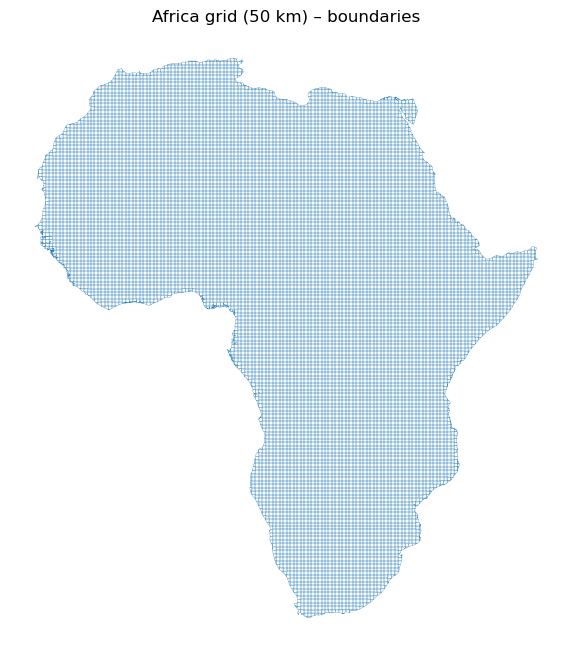

,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2
0,33,-4.440354e+06,2.494190e+06,-4.390354e+06,2.444190e+06,32,0,"MULTIPOLYGON (((-4395047.511 2453227.534, -439...",0,173.800596
1,34,-4.440354e+06,2.444190e+06,-4.390354e+06,2.394190e+06,33,0,"MULTIPOLYGON (((-4392649.973 2399876.219, -439...",1,494.717834
2,35,-4.440354e+06,2.394190e+06,-4.390354e+06,2.344190e+06,34,0,"MULTIPOLYGON (((-4397023.185 2393765.075, -439...",2,208.775375
3,48,-4.440354e+06,1.744190e+06,-4.390354e+06,1.694190e+06,47,0,"MULTIPOLYGON (((-4418194.704 1696932.959, -440...",3,312.911183
4,49,-4.440354e+06,1.694190e+06,-4.390354e+06,1.644190e+06,48,0,"MULTIPOLYGON (((-4391161.005 1654753.532, -439...",4,739.822888


In [2]:
# import all grid versions in EPSG:102022
layers = fiona.listlayers("data/Africa_grid_102022.gpkg")
print("Layers:", layers)
gdf  = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_50km").to_crs("ESRI:102022")
gdf = gdf.reset_index(drop=True)
gdf["cell_id"] = gdf.index.astype("int64")
gdf["area_km2"] = gdf.geometry.area / 1e6  # m² -> km²

# copy dataframe
grid = gdf.copy()

# Visualize grid cells
fig, ax = plt.subplots(figsize=(8, 8))
grid.boundary.plot(ax=ax, linewidth=0.2)
ax.set_title("Africa grid (50 km) – boundaries")
ax.set_axis_off()
plt.show()

# Show dataframe
grid.head()

----------

# Compute counts of conflict incidents per grid cell

### Total conflict incidents

In [3]:
# import ACLED conflict data (EPSG:4326)
conflict_data = gpd.read_file("data/ACLED_conflict-data_africa_2020-2024_4326.gpkg")
conflict_data = conflict_data.to_crs("ESRI:102022")

# fix any invalid grid geometries
grid["geometry"] = grid.geometry.make_valid()

# spatial join: each point gets the cell_id it falls in
pts_with_cellid = gpd.sjoin(conflict_data[["geometry"]],grid[["cell_id", "geometry"]],how="left",predicate="within") # predicate="within" avoids double-counting boundary points, but may drop exact-on-boundary cases

# count points per cell_id
incident_counts = pts_with_cellid.groupby("cell_id").size().rename("incident_count")

# join back to grid; fill empty with zero
grid = grid.join(incident_counts, on="cell_id")
grid["incident_count"] = grid["incident_count"].fillna(0).astype("int64")

# check unmatched points (if high consider changing to predicate="intersects"
print("Total ACLED points:", len(conflict_data))
print("Matched to a cell:", pts_with_cellid["cell_id"].notna().sum())
print("Unmatched:", pts_with_cellid["cell_id"].isna().sum())
print("Grid sum incidents:", grid["incident_count"].sum())

# inspect dataframe
grid.head()

Total ACLED points: 197140
Matched to a cell: 197140
Unmatched: 0
Grid sum incidents: 197140


,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2,incident_count
0,33,-4.440354e+06,2.494190e+06,-4.390354e+06,2.444190e+06,32,0,"MULTIPOLYGON (((-4395047.511 2453227.534, -439...",0,173.800596,0
1,34,-4.440354e+06,2.444190e+06,-4.390354e+06,2.394190e+06,33,0,"MULTIPOLYGON (((-4392649.973 2399876.219, -439...",1,494.717834,14
2,35,-4.440354e+06,2.394190e+06,-4.390354e+06,2.344190e+06,34,0,"MULTIPOLYGON (((-4397023.185 2393765.075, -439...",2,208.775375,207
3,48,-4.440354e+06,1.744190e+06,-4.390354e+06,1.694190e+06,47,0,"MULTIPOLYGON (((-4418194.704 1696932.959, -440...",3,312.911183,6
4,49,-4.440354e+06,1.694190e+06,-4.390354e+06,1.644190e+06,48,0,"MULTIPOLYGON (((-4391161.005 1654753.532, -439...",4,739.822888,368


### Counts by incident type

In [4]:
# 1) spatial join (keep EVENT_TYPE + cell_id)
pts = gpd.sjoin(conflict_data[["EVENT_TYPE", "geometry"]],grid[["cell_id", "geometry"]],how="left",predicate="within")

# 2) counts per cell per event type -> wide columns
counts_wide = (pts.groupby(["cell_id", "EVENT_TYPE"]).size().unstack(fill_value=0))

# 3) clean column names
counts_wide.columns = ["count_" + str(c).lower().replace("/", "_").replace(" ", "_").replace("-", "_") for c in counts_wide.columns]

# 4) join to grid (safe overwrite if re-running)
grid = grid.drop(columns=counts_wide.columns, errors="ignore")
grid = grid.join(counts_wide, on="cell_id")

# 5) fix nans
event_cols = counts_wide.columns.tolist()
grid[event_cols] = grid[event_cols].fillna(0).astype("int64")

# 6) compute total
grid["count_total"] = grid[event_cols].sum(axis=1).astype("int64")

# Check counts
grid[[c for c in grid.columns if c.startswith("cnt_")]].sum().sort_values(ascending=False)

Series([], dtype: float64)

# Compute estimated population per grid cell

In [5]:
# use population density raster to estimate population based on grid cell area size
popdens = rxr.open_rasterio("data/GPW_popdensity_africa_4326.tif", masked=True).squeeze()

nodata = popdens.rio.nodata
if nodata is None:
    nodata = -9999
print("Using nodata:", nodata)

popdens_aea = popdens.rio.reproject(grid.crs,resolution=5000,resampling=Resampling.average,nodata=nodata)

px_w, px_h = popdens_aea.rio.resolution()
pixel_area_km2 = abs(px_w * px_h) / 1e6
people_per_pixel = popdens_aea * pixel_area_km2

grid["pop_est"] = 0.0
chunk_size = 5000

for start in range(0, len(grid), chunk_size):
    chunk = grid.iloc[start:start+chunk_size]
    zs = zonal_stats(chunk,np.asarray(people_per_pixel.values),affine=people_per_pixel.rio.transform(),nodata=nodata,stats=["sum"],all_touched=False)
    grid.loc[chunk.index, "pop_est"] = [d["sum"] if d["sum"] is not None else 0 for d in zs]

grid["pop_est"] = grid["pop_est"].round().astype("int64")

grid.head()

Using nodata: nan


,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2,incident_count,count_battles,count_explosions_remote_violence,count_protests,count_riots,count_strategic_developments,count_violence_against_civilians,count_total,pop_est
0,33,-4.440354e+06,2.494190e+06,-4.390354e+06,2.444190e+06,32,0,"MULTIPOLYGON (((-4395047.511 2453227.534, -439...",0,173.800596,0,0,0,0,0,0,0,0,100
1,34,-4.440354e+06,2.444190e+06,-4.390354e+06,2.394190e+06,33,0,"MULTIPOLYGON (((-4392649.973 2399876.219, -439...",1,494.717834,14,1,1,11,0,0,1,14,6082
2,35,-4.440354e+06,2.394190e+06,-4.390354e+06,2.344190e+06,34,0,"MULTIPOLYGON (((-4397023.185 2393765.075, -439...",2,208.775375,207,0,0,196,8,3,0,207,174040
3,48,-4.440354e+06,1.744190e+06,-4.390354e+06,1.694190e+06,47,0,"MULTIPOLYGON (((-4418194.704 1696932.959, -440...",3,312.911183,6,0,0,2,2,2,0,6,991909
4,49,-4.440354e+06,1.694190e+06,-4.390354e+06,1.644190e+06,48,0,"MULTIPOLYGON (((-4391161.005 1654753.532, -439...",4,739.822888,368,3,0,154,146,55,10,368,2678336


# Compute paved road kilometers per grid cell

In [6]:
# import roads and reproject to equidistant crs
roads = gpd.read_file("data/Africa_roads_4326.gpkg")
crs_len = "ESRI:102023"
roads_len = roads.to_crs(crs_len)
grid_len = grid.to_crs(crs_len)

# keep only line geometries; drop empties
roads_len = roads_len[roads_len.geometry.notna()].copy()
roads_len = roads_len[~roads_len.geometry.is_empty].copy()

# fix invalid geometries
roads_len["geometry"] = roads_len.geometry.make_valid()
grid_len["geometry"] = grid_len.geometry.make_valid()

# spatial index overlay (intersection) creates road segments clipped to each cell polygon
roads_x = gpd.overlay(roads_len[["geometry"]],grid_len[["cell_id", "geometry"]],how="intersection",keep_geom_type=True)

# length in km
roads_x["road_km"] = roads_x.geometry.length / 1000.0

# sum per cell
road_km_by_cell = roads_x.groupby("cell_id")["road_km"].sum()

# write back onto main grid (in 102022) by cell_id
grid["road_km"] = grid["cell_id"].map(road_km_by_cell).fillna(0.0)

grid.head()

,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2,incident_count,count_battles,count_explosions_remote_violence,count_protests,count_riots,count_strategic_developments,count_violence_against_civilians,count_total,pop_est,road_km
0,33,-4.440354e+06,2.494190e+06,-4.390354e+06,2.444190e+06,32,0,"MULTIPOLYGON (((-4395047.511 2453227.534, -439...",0,173.800596,0,0,0,0,0,0,0,0,100,0.000000
1,34,-4.440354e+06,2.444190e+06,-4.390354e+06,2.394190e+06,33,0,"MULTIPOLYGON (((-4392649.973 2399876.219, -439...",1,494.717834,14,1,1,11,0,0,1,14,6082,63.666860
2,35,-4.440354e+06,2.394190e+06,-4.390354e+06,2.344190e+06,34,0,"MULTIPOLYGON (((-4397023.185 2393765.075, -439...",2,208.775375,207,0,0,196,8,3,0,207,174040,56.588894
3,48,-4.440354e+06,1.744190e+06,-4.390354e+06,1.694190e+06,47,0,"MULTIPOLYGON (((-4418194.704 1696932.959, -440...",3,312.911183,6,0,0,2,2,2,0,6,991909,123.114000
4,49,-4.440354e+06,1.694190e+06,-4.390354e+06,1.644190e+06,48,0,"MULTIPOLYGON (((-4391161.005 1654753.532, -439...",4,739.822888,368,3,0,154,146,55,10,368,2678336,380.119706


# Compute distance between cell centroid and nearest border (national, colonial, religious, ethnic)

In [7]:
def compute_dist_to_border(gdf, border_name, file):
    #import borders data
    borders = gpd.read_file(file)
    print("Borders CRS:", borders.crs)
    
    # set target crs for distance calculations in meters
    crs_dist = "ESRI:102023"
    
    # compute centroids
    centroids = gdf[["cell_id", "geometry"]].copy()
    centroids["geometry"] = centroids.geometry.centroid
    
    # make sure both grid and border data are in crs for distance calculation
    centroids = centroids.to_crs(crs_dist)
    borders = borders.to_crs(crs_dist)
    
    # drop empties + make valid
    borders = borders[borders.geometry.notna() & ~borders.geometry.is_empty].copy()
    borders["geometry"] = borders.geometry.make_valid()
    
    # nearest border + distance (uses spatial index)
    nearest = gpd.sjoin_nearest(centroids,borders[["geometry"]],how="left",distance_col=f"dist_{border_name}_m"
    )
    
    # attach back to grid (in your original CRS) ---- FIXED
    dist_by_cell = nearest.groupby("cell_id")[f"dist_{border_name}_m"].min()  # one value per cell_id
    gdf[f"dist_{border_name}_m"] = gdf["cell_id"].map(dist_by_cell.to_dict())
    gdf[f"dist_{border_name}_km"] = gdf[f"dist_{border_name}_m"] / 1000.0
    
    return gdf

In [8]:
grid_w_nationalborders = compute_dist_to_border(grid, "national_border", "data/africa_national-borders_102023.gpkg")
grid_w_colonialborders = compute_dist_to_border(grid, "colonial_border", "data/africa_colonial-borders_102023.gpkg")
grid_w_religiousborders = compute_dist_to_border(grid, "religious_border", "data/africa_religion-borders_102023.gpkg")
grid_w_ethnicborders = compute_dist_to_border(grid, "ethnic_border", "data/africa_ethnic-borders_102023.gpkg")

Borders CRS: PROJCS["Africa_Equidistant_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Equidistant_Conic"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102023"]]
Borders CRS: PROJCS["Africa_Equidistant_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Equidistant_Conic"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_eas

# Export to geopackage for regression analysis notebook

In [9]:
grid.to_file("africa_grid_50km_stats.gpkg", driver="GPKG")